In [26]:
import os
import tensorflow as tf
import numpy as np
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

# Handling images

In [10]:
subj_dir = 'subj01'
data_dir = os.path.join('./algonauts_2023_challenge_data', subj_dir)
train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)
test_img_list = os.listdir(test_img_dir)
train_img_list.sort()
test_img_list.sort()

rand_seed = 5
np.random.seed(rand_seed)
num_train = int(np.round(len(train_img_list) / 100 * 90))
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
idxs_test = np.arange(len(test_img_list))

train_img_paths = [os.path.join(train_img_dir, train_img_file) for train_img_file in train_img_list[:num_train]]
val_img_paths = [os.path.join(train_img_dir, train_img_file) for train_img_file in train_img_list[num_train:]]
test_img_paths = [os.path.join(test_img_dir, test_img_file) for test_img_file in test_img_list]
print('Training images: ' + str(len(train_img_paths)))
print('Validation images: ' + str(len(val_img_paths)))
print('Test images: ' + str(len(test_img_list)))

# SHORTING THE TRAINING IMAGES FOR TESTING
train_img_paths = train_img_paths[:300]
val_img_paths = val_img_paths[:300]

# Preprocessing images specific to ResNet50
def load_and_preprocess_images(images):
    images = [tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224)) for image_path in images] # they do the same resizing in the tutorial
    images = [tf.keras.preprocessing.image.img_to_array(image) for image in images] # 224*224*3
    images = [tf.keras.applications.resnet50.preprocess_input(image) for image in images] # 224*224*3 (preprocessed - what does it do exactly?)
    return images

train_images = load_and_preprocess_images(train_img_paths)
val_images = load_and_preprocess_images(val_img_paths)
test_images = load_and_preprocess_images(test_img_paths)

# Loading the model
base_model = tf.keras.applications.ResNet50(weights='imagenet')
# Specifying the input and output layers
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

Training images: 8857
Validation images: 984
Test images: 159


In [11]:
# create datasets from the images
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.batch(100)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images)
val_dataset = val_dataset.batch(100)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset.batch(100)

# PCA

In [12]:
pca = IncrementalPCA(n_components=50, batch_size=100)

# Fit PCA to batch of datastet
for batch in tqdm(train_dataset):
    print(batch.shape)
    # Extract features
    features = model.predict(batch)
    # Flatten the features
    features = features.reshape(features.shape[0], -1)
    # Fit PCA to batch of features
    pca.partial_fit(features)

  0%|          | 0/3 [00:00<?, ?it/s]

(100, 224, 224, 3)
4/4 [==============================] - 13s 3s/step


 33%|███▎      | 1/3 [00:13<00:26, 13.23s/it]

(100, 224, 224, 3)
4/4 [==============================] - 10s 2s/step


 67%|██████▋   | 2/3 [00:23<00:11, 11.67s/it]

(100, 224, 224, 3)
4/4 [==============================] - 10s 2s/step


100%|██████████| 3/3 [00:33<00:00, 11.27s/it]


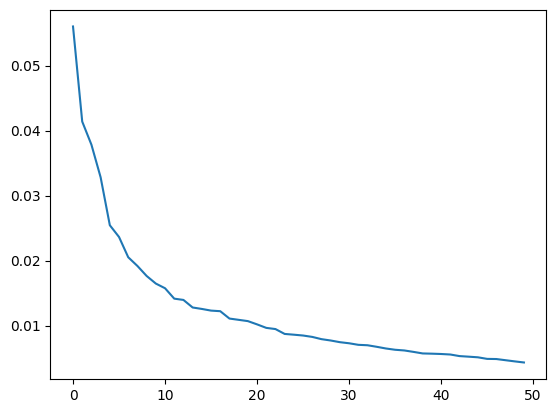

In [13]:
# plot the explained variance
plt.plot(pca.explained_variance_ratio_)

In [14]:
def extract_features(dataset, model, pca):
    features = []
    for batch in tqdm(dataset):
        ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Fit PCA to batch of features
        ft = pca.transform(ft)
        features.append(ft)
    return np.vstack(features) # why do we need to stack the features?


In [15]:
features_train = extract_features(train_dataset, model, pca)
features_val = extract_features(val_dataset, model, pca)
features_test = extract_features(test_dataset, model, pca)

  0%|          | 0/3 [00:00<?, ?it/s]

4/4 [==============================] - 14s 4s/step


 33%|███▎      | 1/3 [00:14<00:29, 14.62s/it]

4/4 [==============================] - 12s 3s/step


 67%|██████▋   | 2/3 [00:26<00:13, 13.05s/it]

4/4 [==============================] - 12s 2s/step


  0%|          | 0/3 [00:00<?, ?it/s]

4/4 [==============================] - 11s 3s/step


 33%|███▎      | 1/3 [00:10<00:21, 10.96s/it]

4/4 [==============================] - 11s 3s/step


 67%|██████▋   | 2/3 [00:21<00:10, 10.86s/it]

4/4 [==============================] - 11s 3s/step


  0%|          | 0/2 [00:00<?, ?it/s]

4/4 [==============================] - 12s 3s/step


 50%|█████     | 1/2 [00:12<00:12, 12.06s/it]

2/2 [==============================] - 6s 3s/step


100%|██████████| 2/2 [00:18<00:00,  9.16s/it]


# Handling frmi files

In [31]:
fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


In [32]:
lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

In [33]:
del lh_fmri, rh_fmri

# Fitting regression

In [39]:
# SHORTEN THE FMRI DATA FOR TESTING
lh_fmri_train = lh_fmri_train[:300]
rh_fmri_train = rh_fmri_train[:300]
lh_fmri_val = lh_fmri_val[:300]
rh_fmri_val = rh_fmri_val[:300]
lh_fmri_val_pred = lh_fmri_val[:300]
rh_fmri_val_pred = rh_fmri_val[:300]

print(lh_fmri_train.shape)
print(rh_fmri_train.shape)
print(features_train.shape)
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)

(300, 19004)
(300, 20544)
(300, 50)


# Calculating correlation

In [40]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

100%|██████████| 20544/20544 [00:01<00:00, 12272.29it/s]


# Visualize

/opt/miniconda3/envs/algonauts/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/algonauts/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


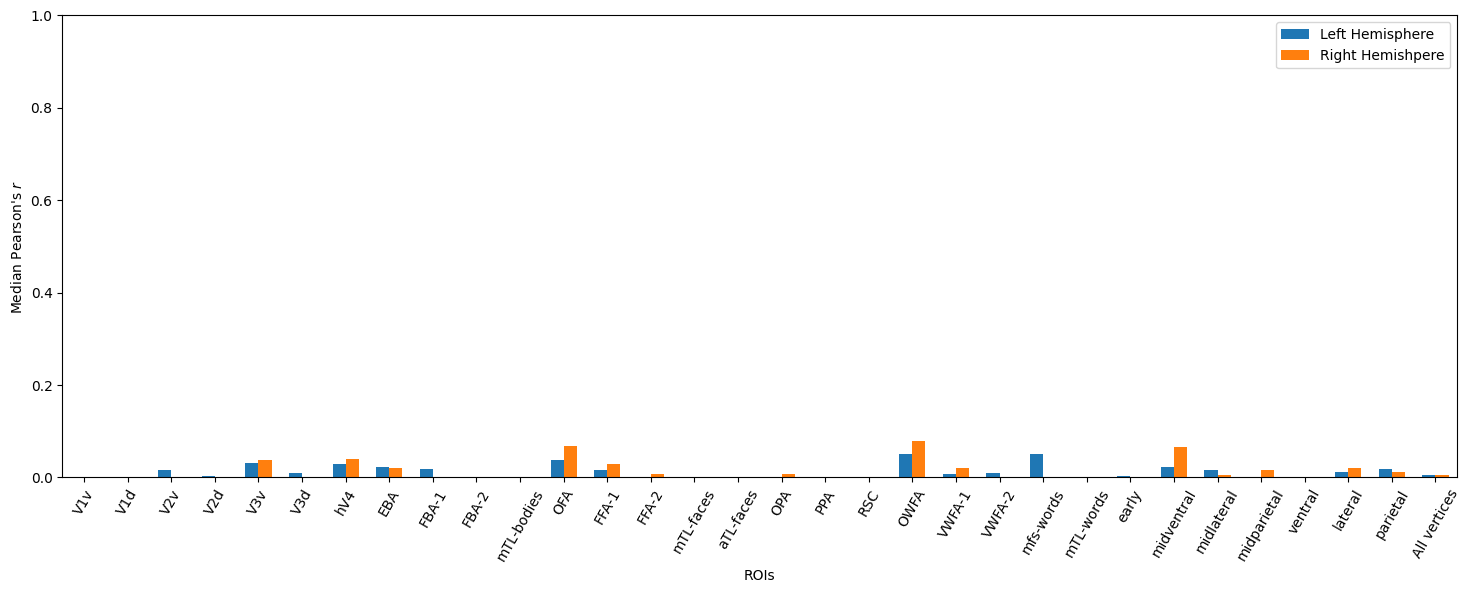

In [42]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);